# Air Voids

In [ ]:
#%% IMPORTS
#BASICS
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from numpy import absolute
from pandas.plotting import scatter_matrix
from sklearn.pipeline import make_pipeline
from IPython.display import display, Markdown, Latex
pd.options.display.max_columns = None

#STATISTICS
from scipy.stats import normaltest
from scipy import stats

#ML TRAINING AND DATA PREPROCESSING
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler
from sklearn.experimental import enable_iterative_imputer
from sklearn.impute import IterativeImputer
from sklearn.preprocessing import PolynomialFeatures

#ML MODELS
from sklearn.tree import DecisionTreeRegressor
from sklearn.linear_model import BayesianRidge
from sklearn.ensemble import ExtraTreesRegressor
from sklearn.linear_model import LinearRegression
from sklearn.linear_model import Ridge
from sklearn.linear_model import SGDRegressor
from sklearn.linear_model import Lasso
from sklearn.linear_model import ElasticNet
from sklearn.svm import SVR
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor
from sklearn.ensemble import ExtraTreesRegressor
from xgboost import XGBRegressor
import xgboost as xgb
from xgboost import plot_importance

#MODEL EVALUATION
from sklearn.model_selection import cross_validate
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import GridSearchCV 
from sklearn.model_selection import RandomizedSearchCV
from sklearn.model_selection import RepeatedKFold

#METRICS
from sklearn.metrics import r2_score
from sklearn.metrics import mean_absolute_error
from sklearn.metrics import mean_squared_error

## 1. Methods

In [ ]:
#Eliminate Outliers based on the interquantile
#datFrame: Data frame where the outliers will be eliminated.
#columnName: the name of the column where the outliers will be identified.
def eliminateOutliers (dataFrame, columnName):
    Q1 = dataFrame[columnName].quantile(0.25)
    Q3 = dataFrame[columnName].quantile(0.75)
    IQR = Q3 - Q1
    print('Initial dataframe size: '+str(dataFrame.shape))
    dataFrame = dataFrame[(dataFrame[columnName] < (Q3 + 1.5 * IQR)) & (dataFrame[columnName] > (Q1 - 1.5 * IQR))]
    print('Final dataframe size: '+str(dataFrame.shape))
    return dataFrame

In [ ]:
# Create the boxplot graphs for the categorical variables
# dataFrame: Data frame associated to the property of interest (dfAirVoids, dfMS, dfMF, dfITS, dfTSR)
# propertyOfInterest: the name of the column where the property of interest is located.
# columnName1...4: The categorical columns to evaluate.
def displayBoxPlotGraphs (dataFrame, propertyOfInterest, columnName1, columnName2, columnName3, columnName4):
    f, ((ax1, ax2), (ax3, ax4)) = plt.subplots(2, 2, figsize=(15,10))
    sns.boxplot(y = propertyOfInterest, x = columnName1, data=dataFrame,  orient='v' , ax=ax1)
    sns.boxplot(y = propertyOfInterest, x = columnName2, data=dataFrame,  orient='v' , ax=ax2)
    sns.boxplot(y = propertyOfInterest, x= columnName3, data=dataFrame,  orient='v' , ax=ax3)
    sns.boxplot(y= propertyOfInterest, x= columnName4, data=dataFrame,  orient='v' , ax=ax4)

In [ ]:
#Method that print the best parameters, R2 and MSE based on a grid search.
def printBestModel (grid):
    mse = -grid.best_score_
    print('Best Parameters:' , grid.best_params_)
    print('Best MSE:' + str(mse))

##  2. Data Import 

In [ ]:
#%%DATA READING AND INITIAL PREPROCESSING
numericColumns = ['Aggregate absorption (%)',
                  'Apparent specific gravity',
                    0.075,
                    0.3,
                    0.6,
                    2.36,
                    4.75,
                    9.5,
                    12.5,
                    19,
                    'Plastic particle size (mm)',
                    'Mixing speed (RPM)',
                    'Mixing Temperature',
                    'Mixing Time (hours)',
                    'Plastic Addition by bitumen weight (%)',
                    'Bitumen content in the sample'
                    ]
categoricalColumns = ['Modified asphalt Mix?',
                      'Agreggate Type',
                    'Aggregate absorption [%]',
                    'Filler used',
                    'Consolidated bitumen penetration grade',
                    'New Plastic Type',
                    'Plastic pretreatment',
                    'Plastic shape',
                    'Plastic Size',
                    'Mixing Process',
                    'Aggregates replacement ?',
                    'Bitumen replacement?',
                    'Filler replacement',
                    'Property',
                    'Units']
#It returns the dataframe of interes based on the property - 'AirVoids', 'MS', 'MF', 'ITS', 'TSR'
def returnDf (propertyOfInterest):
    df = pd.read_excel('fileML.xlsx', sheet_name = propertyOfInterest, engine='openpyxl')
    df = df.set_index(propertyOfInterest + ' ID')
    df.loc[:,:'Units'] = df.loc[:,:'Units'].applymap(str)
    df.loc[:,:'Units'] = df.loc[:,:'Units'] .applymap(str.strip)
    df.replace('NS', np.nan, inplace = True)
    df[numericColumns] = df[numericColumns].replace('N/a', 0).astype(float)
    df.columns = df.columns.astype(str)
    return df

In [ ]:
dfAirVoids = returnDf('AirVoids')
dfMS = returnDf('MS')
dfMF = returnDf('MF')
dfITS = returnDf('ITS')
dfTSR = returnDf('TSR')

## 3. Data Exploration
###  3.1 Total Sample

In [ ]:
dfAirVoids = eliminateOutliers(dfAirVoids, 'Air voids of the sample (%)')

In [ ]:
dfAirVoids.info()

In [ ]:
columnsOfInteres = numericColumns[0:2]+numericColumns[10:]+['Air voids of the sample (%)']

In [ ]:
dfAirVoids.describe(include = 'all')

In total, there is $\color{red}{\text{288}}$ observations. Let's see if there is any correlation with the continual and categorical variables. The mean of $\color{red}{\text{Air voids}}$, which is the common value for the optimum asphalt mix design.

In [ ]:
scatter_matrix(dfAirVoids[['Aggregate absorption [%]', 'Apparent specific gravity', 'Bitumen content in the sample', 'Air voids of the sample (%)']], figsize=(10, 10))
plt.show()

It is possible to see a negative correlation between $\color{red}{\text{Bitumen Content}}$  and $\color{red}{\text{Air Voids}}$. This makes sense because higher bitumen quantities will fill more voids in the mixture.

Among the categorical variables, we will initially focus on the general ones that might have an effect on air voids: $\color{red}{\text{Aggregate type}}$, $\color{red}{\text{Filler used}}$ and $\color{red}{\text{Bitumen Grade}}$

In [ ]:
displayBoxPlotGraphs(dataFrame = dfAirVoids, propertyOfInterest = "Air voids of the sample (%)", columnName1 = "Agreggate Type", columnName2 = "Filler used", columnName3 = "Consolidated bitumen penetration grade", columnName4 = "Modified asphalt Mix?")

Within the  $\color{red}{\text{Aggregate type}}$, although it exists differences -especially with the Ophitic- this data migh not be robust enough due to the sample size of this type of aggregate. It happens the same with the  $\color{red}{\text{Bitumen type}}$, where only  $\color{purple}{\text{5}}$ observations used the 40/50 bitumen. The  $\color{red}{\text{addition of plastic}}$ seems to have not strong influence in the air voids.

In [ ]:
#CORRELATION:
plt.figure(figsize=(16, 6))
heatmap = sns.heatmap(dfAirVoids.corr(), vmin=-1, vmax=1, annot=True)
heatmap.set_title('Correlation Heatmap Air Voids', fontdict={'fontsize':12}, pad=12);

###  3.2 Modified mixtures

In [ ]:
dfAirVoidsModvsUnmod = dfAirVoids [['Modified asphalt Mix?', 'Air voids of the sample (%)']]
dfAirVoidsModvsUnmod.groupby(['Modified asphalt Mix?'], as_index=False).describe()

In [ ]:
dfAirVoidsModified = dfAirVoids[dfAirVoids['Modified asphalt Mix?']=='Yes']
dfAirVoidsModified.describe(include = "all")

In [ ]:
scatter_matrix(dfAirVoidsModified[columnsOfInteres], figsize=(25, 20))
plt.show()

In [ ]:
#CORRELATION:
plt.figure(figsize=(16, 6))
heatmap = sns.heatmap(dfAirVoidsModified.corr(), vmin=-1, vmax=1, annot=True)
heatmap.set_title('Correlation Heatmap', fontdict={'fontsize':12}, pad=12);

In [ ]:
displayBoxPlotGraphs(dataFrame = dfAirVoidsModified, propertyOfInterest = "Air voids of the sample (%)", columnName1 = "Agreggate Type", columnName2 = "Plastic shape", columnName3 = "New Plastic Type", columnName4 = "Mixing Process")

Not much difference among dry and wet

###  3.3 Wet vs. Dry Mixing

In [ ]:
dfAirVoidsWetvsDry = dfAirVoidsModified [['Mixing Process', 'Air voids of the sample (%)']]
dfAirVoidsWetvsDry.groupby(['Mixing Process'], as_index=False).describe()

In [ ]:
sns.pairplot(dfAirVoidsModified[columnsOfInteres+['Mixing Process']], hue="Mixing Process", height=2.5)

##  **Air Voids summary:**

*   There are missing values mainly in $\color{red}{\text{Apparent specific gravity}}$, $\color{red}{\text{Aggregate type}}$ and $\color{red}{\text{filler used}}$.
*   Total sample: # observations = 288, Mean = 4, Standard deviation = 0.98 
*   Sample with asphalt modified: # observations = 228, Mean = 3.94, Standard deviation = 1.017
*   It seems that there will be a strong correlation with $\color{red}{\text{Aggregates gradation}}$.
*   Dry vs. Wet:
    *   Not strong difference between dry and wet.
    *   Mean in wet = 3.64, Mean in dry = 4.16.


## 4. Data Pre-processing

In [ ]:
dfAirVoids.info()

*   Process for dealing with missing categorical values:

    1.  I will eliminate the rows with Nan values in the column $\color{red}{\text{New Plastic Type}}$. In total, there is 24 missing values, which represent 8.33% of the sample
    2.  Replace the 'N/a' value when there is no modifiation of the asphalt mix.

*   Process for dealing with missing numeric values:

    *   The imputer used was the multivariable imputer, and the estimator was the ExtraTreeRegressor ([link][1]).
    By using this estimator, I did not get any negative values among the missing features, and it presents a low MSE value.
    
[1]:https://scikit-learn.org/stable/auto_examples/impute/plot_iterative_imputer_variants_comparison.html#sphx-glr-auto-examples-impute-plot-iterative-imputer-variants-comparison-py  

In [ ]:
#Categorical Variables
dfAirVoidsCleaned = dfAirVoids.drop(['Article ID', 
                                    'Global ID',
                                    'Modified asphalt Mix?',
                                    'Agreggate Type', 
                                    'Apparent specific gravity', 
                                    'Filler used', 
                                    'Bitumen Type Penetration Grade', 
                                    'Property', 
                                    'Units', 
                                    'Plastic Size' ], axis = 1)
dfAirVoidsCleaned = dfAirVoidsCleaned.replace('N/a', 0)
dfAirVoidsCleaned = dfAirVoidsCleaned.dropna(subset=['New Plastic Type'])
dfAirVoidsCleaned = pd.get_dummies(dfAirVoidsCleaned, columns=['New Plastic Type'], drop_first=False)
dfAirVoidsCleaned = pd.get_dummies(dfAirVoidsCleaned, drop_first=True)
dfAirVoidsCleaned = dfAirVoidsCleaned.drop(['New Plastic Type_0'], axis = 1)

In [ ]:
#IMPUTATION OF MISSING VALUES
imputer = IterativeImputer (estimator = ExtraTreesRegressor(n_estimators=10, random_state = 123), max_iter=50,random_state = 123)
n = imputer.fit_transform(dfAirVoidsCleaned)
dfAirVoidsCleanedImputed = pd.DataFrame(n, columns = list(dfAirVoidsCleaned.columns))
print ('There is '+str(sum(n < 0 for n in dfAirVoidsCleanedImputed.values.flatten()))+' negative values in the new Dataframe')

In [ ]:
dfAirVoidsCleanedImputed['New Plastic Type_Nylon'] = dfAirVoidsCleanedImputed['New Plastic Type_Nylon'] * dfAirVoidsCleanedImputed['Plastic Addition by bitumen weight (%)']
dfAirVoidsCleanedImputed['New Plastic Type_PE'] = dfAirVoidsCleanedImputed['New Plastic Type_PE'] * dfAirVoidsCleanedImputed['Plastic Addition by bitumen weight (%)']
dfAirVoidsCleanedImputed['New Plastic Type_PET'] = dfAirVoidsCleanedImputed['New Plastic Type_PET'] * dfAirVoidsCleanedImputed['Plastic Addition by bitumen weight (%)']
dfAirVoidsCleanedImputed['New Plastic Type_PP'] = dfAirVoidsCleanedImputed['New Plastic Type_PP'] * dfAirVoidsCleanedImputed['Plastic Addition by bitumen weight (%)']
dfAirVoidsCleanedImputed['New Plastic Type_PS'] = dfAirVoidsCleanedImputed['New Plastic Type_PS'] * dfAirVoidsCleanedImputed['Plastic Addition by bitumen weight (%)']
dfAirVoidsCleanedImputed['New Plastic Type_PU'] = dfAirVoidsCleanedImputed['New Plastic Type_PU'] * dfAirVoidsCleanedImputed['Plastic Addition by bitumen weight (%)']
dfAirVoidsCleanedImputed['New Plastic Type_Plastic Mix'] = dfAirVoidsCleanedImputed['New Plastic Type_Plastic Mix'] * dfAirVoidsCleanedImputed['Plastic Addition by bitumen weight (%)']
dfAirVoidsCleanedImputed = dfAirVoidsCleanedImputed.drop(['Plastic Addition by bitumen weight (%)'], axis = 1)

In [ ]:
 #Feature Scaling
 scaler = MinMaxScaler()
 dfAirVoidsCleanedImputedScaled = pd.DataFrame(scaler.fit_transform(dfAirVoidsCleanedImputed), columns = list(dfAirVoidsCleanedImputed.columns))
 dfAirVoidsCleanedImputedScaled.to_clipboard()

In [ ]:
dfAirVoidsCleanedImputed.info()

## 5. Model Training

In [ ]:
X = dfAirVoidsCleanedImputedScaled.loc[:, dfAirVoidsCleanedImputedScaled.columns != 'Air voids of the sample (%)']
y = dfAirVoidsCleanedImputedScaled.loc[:,'Air voids of the sample (%)']
cv = RepeatedKFold(n_splits = 5, n_repeats = 10, random_state = 123)

### 5.1m Model Evaluation
#### Linear Model

In [ ]:
param_grid = {'fit_intercept': [True, False],
            'positive': [True, False]}
grid = GridSearchCV(LinearRegression(), param_grid, cv = cv, scoring=['neg_mean_squared_error'], refit = 'neg_mean_squared_error', return_train_score= True)
grid.fit(X, y)
printBestModel(grid)

#### Lasso Linear Model


In [ ]:
param_grid = {'alpha': [0.001,1, 10, 15, 30, 50, 100],
            'fit_intercept':[True, False],
            'positive': [True, False]}
grid = GridSearchCV(Lasso(), param_grid, cv=cv, scoring=['neg_mean_squared_error'], refit = 'neg_mean_squared_error', return_train_score= True)
grid.fit(X, y)
printBestModel(grid)

#### Ridge linear regression model

In [ ]:
param_grid = {'alpha': [7, 8, 10,100],
'fit_intercept': [True, False],
'solver': [ 'svd', 'cholesky', 'lsqr', 'sparse_cg', 'sag', 'saga']}
grid = GridSearchCV(Ridge(), param_grid, cv=cv, scoring=['neg_mean_squared_error'], refit = 'neg_mean_squared_error')
grid.fit(X, y)
printBestModel(grid)

#### Linear Elastic Net

In [ ]:
param_grid = {'alpha': [0.01,1,2,3,4],
'fit_intercept': [True, False]}
grid = GridSearchCV(ElasticNet(), param_grid, cv=cv, scoring=['neg_mean_squared_error'], refit = 'neg_mean_squared_error')
grid.fit(X, y)
printBestModel(grid)

#### Polynomial Model

In [ ]:
def PolynomialRegression(degree=2, **kwargs):
    return make_pipeline(PolynomialFeatures(degree), LinearRegression(**kwargs))

param_grid = {'polynomialfeatures__degree': [2,3],
'linearregression__fit_intercept': [True, False],
'linearregression__positive':[True, False]}
grid = GridSearchCV(PolynomialRegression(), param_grid, cv=cv, scoring=['neg_mean_squared_error'], refit = 'neg_mean_squared_error')
grid.fit(X, y)
printBestModel(grid)

#### Lasso Polynomial Model

In [ ]:
def PolynomialRegression(degree=2, **kwargs):
    return make_pipeline(PolynomialFeatures(degree), Lasso(**kwargs))

param_grid = {'polynomialfeatures__degree': [2,3],
            'lasso__alpha': [1,2, 3, 10, 15, 30],
            'lasso__fit_intercept':[True, False],
            'lasso__positive': [True, False],
            'lasso__max_iter': [2000,3000, 3500]}
grid = GridSearchCV(PolynomialRegression(), param_grid, cv=cv, scoring=['neg_mean_squared_error'], refit = 'neg_mean_squared_error', return_train_score= True)
grid.fit(X, y)
printBestModel(grid)

#### Ridge polynomial regression

In [ ]:
def PolynomialRegression(degree=2, **kwargs):
    return make_pipeline(PolynomialFeatures(degree), Ridge(**kwargs))

param_grid = {'polynomialfeatures__degree': [2,3],
'ridge__alpha':[20,30,50, 60],
'ridge__fit_intercept': [True, False],
'ridge__solver': [ 'lsqr', 'cholesky', 'sparse_cg', 'auto']}
grid = GridSearchCV(PolynomialRegression(), param_grid, cv=cv, scoring=['neg_mean_squared_error'], refit='neg_mean_squared_error')
grid.fit(X, y)
printBestModel(grid)

#### Support vector regression

In [ ]:
param_grid = {
    'kernel':['linear','rbf', 'sigmoid', 'poly'],
    'degree':[2,3,4],
    'C':[0.01,1,5,10],
    'epsilon':[0.1,0.2, 1, 1.5]
}
grid = GridSearchCV(SVR(), param_grid, cv=cv, scoring=['neg_mean_squared_error'], refit='neg_mean_squared_error')
grid.fit(X, y)
printBestModel(grid)

#### Decision tree regressor

In [ ]:
param_grid = {
    'max_depth':[1,2,3,5,10,30],
    'min_samples_split':[2,3,4],
    'min_samples_leaf':[0.4,1,2]
}
grid = GridSearchCV(DecisionTreeRegressor(), param_grid, cv=cv, scoring=['neg_mean_squared_error'], refit='neg_mean_squared_error')
grid.fit(X, y)
printBestModel(grid)

#### Random Forest


In [ ]:
# Number of trees in random forest
n_estimators = [int(x) for x in np.linspace(start = 200, stop = 2000, num = 10)]
# Number of features to consider at every split
max_features = ['auto', 'sqrt']
# Maximum number of levels in tree
max_depth = [int(x) for x in np.linspace(10, 110, num = 11)]
max_depth.append(None)
# Minimum number of samples required to split a node
min_samples_split = [2, 5, 10]
# Minimum number of samples required at each leaf node
min_samples_leaf = [1, 2, 4]
# Method of selecting samples for training each tree
bootstrap = [True, False]
# Create the random grid
random_grid = {'n_estimators': n_estimators,
               'max_features': max_features,
               'max_depth': max_depth,
               'min_samples_split': min_samples_split,
               'min_samples_leaf': min_samples_leaf,
               'bootstrap': bootstrap}
grid = RandomizedSearchCV(RandomForestRegressor(), 
                        random_grid, 
                        cv=cv, 
                        scoring=['neg_mean_squared_error'], 
                        refit='neg_mean_squared_error', 
                        n_iter=100,
                        )
grid.fit(X, y)
printBestModel(grid)

#### Extra tree regressor

In [ ]:
param_grid = {
    'bootstrap': [True, False],
    'max_depth': [10, 20, 30, 40, 50, 60, 70, 80, 90, 100, None],
    'max_features': ['auto', 'sqrt'],
    'min_samples_leaf': [1, 2, 4],
    'min_samples_split': [2, 5, 10],
    'n_estimators': [200, 400, 600, 800, 1000, 1200, 1400, 1600, 1800, 2000]
}
grid = RandomizedSearchCV(ExtraTreesRegressor(), param_grid, cv=cv, scoring=['neg_mean_squared_error'], refit='neg_mean_squared_error', n_iter=10)
grid.fit(X, y)
printBestModel(grid)

#### XG Boost Regressor

In [ ]:
XGBoostModel = XGBRegressor()
scores = cross_val_score(XGBoostModel, X, y , scoring = 'neg_mean_squared_error', cv = cv)
scores = np.absolute(scores)
print (scores.mean())

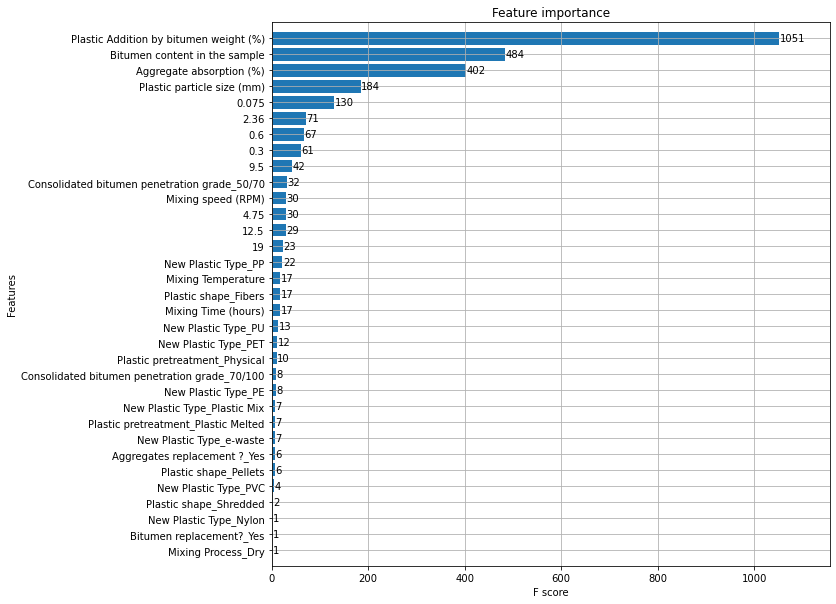

In [65]:
#Graph employed for selecting important features during tunning
XGBoostModel.fit(X,y)
ax = plot_importance(XGBoostModel, height=0.8)
fig = ax.figure
fig.set_size_inches(10,10)


## 6. Best Model Tunning

In [ ]:
X.columns = X.columns.astype(str)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=123)
cv = RepeatedKFold(n_splits = 5, n_repeats = 15, random_state = 123)

### 6.1. Feature selection

In [ ]:
def evaluatefeatures (X = X, y = y):
    cv_results = cross_validate(XGBRegressor(random_state = 1), X, y, cv = cv, scoring = ['r2', 'neg_mean_squared_error'], return_train_score = True)
    print ('R2 in train set:' + str(np.average(cv_results['train_r2'])))
    print ('MSE in train set:' + str(np.average(-cv_results['train_neg_mean_squared_error'])))
    print ('R2 in test set:' + str(np.average(cv_results['test_r2'])))
    print ('MSE in test set:' + str(np.average(-cv_results['test_neg_mean_squared_error'])))   

In [ ]:
X_train.columns

In [ ]:
evaluatefeatures(X = X_train, y = y_train)

In [ ]:
evaluatefeatures( X = X_train[['0.075', '0.3', '0.6', '2.36', '4.75','9.5', '12.5', '19']], y = y_train)

In [ ]:
evaluatefeatures( X = X_train[['0.075', '0.3', '0.6', '2.36', '4.75','9.5', '12.5', '19',
                        'Bitumen content in the sample']], y = y_train)

In [ ]:
evaluatefeatures( X = X_train[['0.075', '0.3', '0.6', '2.36', '4.75','9.5', '12.5', '19',
                        'Bitumen content in the sample',
                        'Consolidated bitumen penetration grade_50/70',
                        'Consolidated bitumen penetration grade_70/100',]], y = y_train)

In [ ]:
evaluatefeatures( X = X_train[['0.075', '0.3', '0.6', '2.36', '4.75','9.5', '12.5', '19',
                        'Bitumen content in the sample',
                        'New Plastic Type_Nylon',
                        'New Plastic Type_PE', 
                        'New Plastic Type_PET', 
                        'New Plastic Type_PP',
                        'New Plastic Type_PS', 
                        'New Plastic Type_PU',
                        'New Plastic Type_Plastic Mix',
                        ]], y = y_train)

In [ ]:
evaluatefeatures( X = X_train[['0.075', '0.3', '0.6', '2.36', '4.75','9.5', '12.5', '19',
                        'Aggregate absorption (%)',
                        'Bitumen content in the sample',
                        'New Plastic Type_Nylon',
                        'New Plastic Type_PE', 
                        'New Plastic Type_PET', 
                        'New Plastic Type_PP',
                        'New Plastic Type_PS', 
                        'New Plastic Type_PU',
                        'New Plastic Type_Plastic Mix',
                        ]], y = y_train)

In [ ]:
evaluatefeatures( X = X_train[['0.075', '0.3', '0.6', '2.36', '4.75','9.5', '12.5', '19',
                        'Aggregate absorption (%)',
                        'Bitumen content in the sample',
                        'New Plastic Type_Nylon',
                        'New Plastic Type_PE', 
                        'New Plastic Type_PET', 
                        'New Plastic Type_PP',
                        'New Plastic Type_PS', 
                        'New Plastic Type_PU',
                        'New Plastic Type_Plastic Mix',
                        'Plastic particle size (mm)'
                        ]], y = y_train)

In [ ]:
evaluatefeatures( X = X_train[['0.075', '0.3', '0.6', '2.36', '4.75','9.5', '12.5', '19',
                        'Aggregate absorption (%)',
                        'Bitumen content in the sample',
                        'New Plastic Type_Nylon',
                        'New Plastic Type_PE', 
                        'New Plastic Type_PET', 
                        'New Plastic Type_PP',
                        'New Plastic Type_PS', 
                        'New Plastic Type_PU',
                        'New Plastic Type_Plastic Mix',
                        'Plastic particle size (mm)',
                        'Mixing Process_Dry', 
                        'Mixing Process_Wet',
                        ]], y = y_train)

The features most approppiate for the model are aggregates gradation, bitumen content, plastic type, plastic addition, aggregate absorption and plastic particle size.
### 6.2 Model Tunning

In [ ]:
X_train =  X_train[['0.075', '0.3', '0.6', '2.36', '4.75','9.5', '12.5', '19',
        'Aggregate absorption (%)',
        'Bitumen content in the sample',
        'New Plastic Type_Nylon',
        'New Plastic Type_PE', 
        'New Plastic Type_PET', 
        'New Plastic Type_PP',
        'New Plastic Type_PS', 
        'New Plastic Type_PU',
        'New Plastic Type_Plastic Mix',
        'Plastic particle size (mm)'
        ]]
X_test = X_test [['0.075', '0.3', '0.6', '2.36', '4.75','9.5', '12.5', '19',
        'Aggregate absorption (%)',
        'Bitumen content in the sample',
        'New Plastic Type_Nylon',
        'New Plastic Type_PE', 
        'New Plastic Type_PET', 
        'New Plastic Type_PP',
        'New Plastic Type_PS', 
        'New Plastic Type_PU',
        'New Plastic Type_Plastic Mix',
        'Plastic particle size (mm)'
        ]]

In [ ]:
X.head(10)

In [ ]:
def tuning_evaluation (parameters, X, y):
    param_grid = parameters
    grid = GridSearchCV(XGBRegressor(random_state = 1), param_grid, cv=cv, scoring=['neg_mean_squared_error', 'r2'], refit='neg_mean_squared_error')
    grid.fit(X, y)
    test_MSE = -grid.cv_results_['mean_test_neg_mean_squared_error'][grid.best_index_]
    test_r2 = grid.cv_results_['mean_test_r2'][grid.best_index_]
    best_param = grid.best_params_
    print ('r2 test: ' + str(test_r2))
    print ('MSE test: ' + str(test_MSE))
    print ('Best Parameters ' + str(best_param))

In [ ]:
param_grid = {
        'eta':[0.1, 0.2, 0.3, 0.4, 0.5]
    }
tuning_evaluation (param_grid, X_train, y_train)

In [ ]:
param_grid = {
        'eta':[0.3],
        'max_depth':np.arange(3,11,1)
    }
tuning_evaluation (param_grid, X_train, y_train)

In [ ]:
param_grid = {
        'eta':[0.3],
        'max_depth':[6],
        'min_child_weight':np.arange(1,11,1)
    }
tuning_evaluation (param_grid, X = X_train, y = y_train)

In [ ]:
param_grid = {
        'eta':[0.3],
        'max_depth':[6],
        'min_child_weight':[1],
        'max_delta_step': np.arange(0,11,1)
    }
tuning_evaluation (param_grid, X = X_train, y = y_train)

In [ ]:
param_grid = {
        'eta':[0.3],
        'max_depth':[6],
        'min_child_weight':[1],
        'max_delta_step': [0],
        'gamma' : [0, 0.001, 0.01, 0.1, 1, 10]
    }
tuning_evaluation (param_grid, X = X_train, y = y_train)

In [ ]:
param_grid = {
        'eta':[0.3],
        'max_depth':[6],
        'min_child_weight':[1],
        'max_delta_step': [0],
        'gamma' : [0],
        'subsample' : np.arange(0.5, 1.1, 0.1)
    }
tuning_evaluation (param_grid, X = X_train, y = y_train)

In [ ]:
param_grid = {
        'eta':[0.3],
        'max_depth':[6],
        'min_child_weight':[1],
        'max_delta_step': [0],
        'gamma' : [0],
        'subsample' : [1],
        'colsample_bytree':[0, 0.5 ,1],
        'colsample_bylevel':[0, 0.5 ,1],
        'colsample_bynode':[0, 0.5 ,1]
    }
tuning_evaluation (param_grid, X = X_train, y = y_train)

In [ ]:
param_grid = {
        'eta':[0.3],
        'max_depth':[6],
        'min_child_weight':[1],
        'max_delta_step': [0],
        'gamma' : [0],
        'subsample' : [1],
        'colsample_bytree':[1],
        'colsample_bylevel':[1],
        'colsample_bynode':[1],
        'lambda' : np.arange(5,15,1)
    }
tuning_evaluation (param_grid, X = X_train, y = y_train)

In [ ]:
param_grid = {
        'eta':[0.3],
        'max_depth':[6],
        'min_child_weight':[1],
        'max_delta_step': [0],
        'gamma' : [0],
        'subsample' : [1],
        'colsample_bytree':[1],
        'colsample_bylevel':[1],
        'colsample_bynode':[1],
        'lambda' : [13],
        'alpha' : np.arange(0,11,1)
    }
tuning_evaluation (param_grid, X = X_train, y = y_train)

In [ ]:
param_grid = {
        'eta':[0.3],
        'max_depth':[6],
        'min_child_weight':[1],
        'max_delta_step': [0],
        'gamma' : [0],
        'subsample' : [1],
        'colsample_bytree':[1],
        'colsample_bylevel':[1],
        'colsample_bynode':[1],
        'lambda' : [13],
        'alpha' : [0],
        'tree_method' : ['exact', 'approx', 'hist', 'gpu_hist']
    }
tuning_evaluation (param_grid, X = X_train, y = y_train)

In [ ]:
param_grid = {
        'eta':[0.3],
        'max_depth':[6],
        'min_child_weight':[1],
        'max_delta_step': [0],
        'gamma' : [0],
        'subsample' : [1],
        'colsample_bytree':[1],
        'colsample_bylevel':[1],
        'colsample_bynode':[1],
        'lambda' : [13],
        'alpha' : [0],
        'tree_method' : ['approx'],
    }
tuning_evaluation (param_grid, X = X_train, y = y_train)

### 6.3 Final model evaluation on test set

In [ ]:
XGModel = XGBRegressor(random_state = 1,
                        eta = 0.3,
                        max_depth = 6,
                        min_child_weight =1,
                        max_delta_step = 0,
                        gamma = 0,
                        subsample = 1,
                        colsample_bytree = 1,
                        colsample_bylevel = 1,
                        colsample_bynode = 1, 
                        reg_lambda = 13,
                        alpha = 0,
                        tree_method = 'approx')
XGModel.fit(X_train, y_train)
predictions_test = XGModel.predict(X_test)
r2_test = r2_score(y_test, predictions_test)
mse_test = mean_squared_error(y_test, predictions_test)
print('The test r2 is: ' + str(r2_test))
print('The test MSE is: ' + str(mse_test))
predictions_train = XGModel.predict(X_train)
r2_train = r2_score(y_train, predictions_train)
mse_train = mean_squared_error(y_train, predictions_train)
print('The test r2 is: ' + str(r2_train))
print('The test MSE is: ' + str(mse_train))

In [ ]:
ax = xgb.plot_importance(XGModel, height=0.8, importance_type = 'gain', show_values = False)
fig = ax.figure
fig.set_size_inches(6,10)

In [ ]:
features_importance = pd.DataFrame(np.c_[np.array(X_train.columns), XGModel.feature_importances_], columns = ['feature', 'importance'])
features_importance = features_importance.sort_values('importance', ascending = False, ignore_index = True)
features_importance['sum'] = features_importance['importance'].cumsum()
features_importance

In [ ]:
ax = xgb.plot_tree(XGModel)
fig = ax.figure
fig.set_size_inches(20,20)

-------------------------------
#  2. Marshall Stability

In [ ]:
dfMS = eliminateOutliers(dfMS, 'MS of the sample (kN)')

## 2.1 Data Exploration
###  2.1.1 Total Sample

In [ ]:
dfMS.describe(include = "all")
dfMS.info()

In [ ]:
dfMS.iloc[:,2:].describe(include = 'all')

I might have a problem with the $\color{red}{\text{Aggregate absorption}}$ because more than 20% of the data is missing. Regarding the $\color{red}{\text{MS}}$, there is a high dispersion ($\sigma$ = 4.56), and the Mean seems normal. According to the Australian standards, the minimum value of the Marshall stability is between two and eigth.

In [ ]:
scatter_matrix(dfMS[['Aggregate absorption [%]', 'Apparent specific gravity', 'Bitumen content in the sample', 'MS of the sample (kN)']], figsize=(10, 10))
plt.show()

In [ ]:
plt.figure(figsize=(16, 6))
heatmap = sns.heatmap(dfMS.corr(), vmin=-1, vmax=1, annot=True)
heatmap.set_title('Correlation Heatmap MS', fontdict={'fontsize':12}, pad=12);

Interestingly, there is positive correlation in $\color{red}{\text{MS-Apparent specific gravity}}$ and $\color{red}{\text{MS-plastic addition by bitumen content}}$.


In [ ]:
displayBoxPlotGraphs(dataFrame = dfMS, propertyOfInterest = "MS of the sample (kN)", columnName1 = "Agreggate Type", columnName2 = "Filler used", columnName3 = "Consolidated bitumen penetration grade", columnName4 = "Modified asphalt Mix?")

*   As it happened with the Air Voids, it exists a MS difference among the samples that employed the bitumen 40/50; however, it is important to note that the sample size for this group was not representative enough.

*   Samples with plastic modification tend to have higher MS. The glue effect of the plastic and the stiffness increase of the bitumen might serve as valid explanations.

*   No signigicant difference among the aggregate types and fillers

###  2.1.2 Modified mixtures

In [ ]:
dfMSModvsUnmod = dfMS [['Modified asphalt Mix?', 'MS of the sample (kN)']]
dfMSModvsUnmod.groupby(['Modified asphalt Mix?'], as_index=False).describe()

In [ ]:
dfMSModified = dfMS[dfMS['Modified asphalt Mix?'] == 'Yes']
dfMSModified.describe(include = "all")

In [ ]:
columnsOfInteres = numericColumns[0:2]+numericColumns[10:]+['MS of the sample (kN)']
scatter_matrix(dfMSModified[columnsOfInteres], figsize=(25, 20))
plt.show()

In [ ]:
plt.figure(figsize=(16, 6))
heatmap = sns.heatmap(dfMSModified.corr(), vmin=-1, vmax=1, annot=True)
heatmap.set_title('Correlation Heatmap MS', fontdict={'fontsize':12}, pad=12)

 $\color{red}{\text{MS-Apparent specific gravity}}$ presents the highest correlation with  $\color{red}{\text{MS}}$; however, it only has 66 observations, so it is not a convincing result. Other parameters such as  $\color{red}{\text{Plastic content}}$, and  $\color{red}{\text{gradation}}$ present an slight effect on the MS.

In [ ]:
displayBoxPlotGraphs(dataFrame = dfMSModified, propertyOfInterest = "MS of the sample (kN)", columnName1 = "Agreggate Type", columnName2 = "Plastic shape", columnName3 = "New Plastic Type", columnName4 = "Mixing Process")

The mean of the **dry** and **wet** process are not significantly different.

###  2.1.3 Wet vs. Dry Mixing

In [ ]:
dfMSWetvsDry = dfMSModified [['Mixing Process', 'MS of the sample (kN)']]
dfMSWetvsDry.groupby(['Mixing Process'], as_index=False).describe()

In [ ]:
sns.pairplot(dfMSModified[columnsOfInteres+['Mixing Process']], hue="Mixing Process", height=2.5)

##  **MS summary:**

*   There are missing values mainly in $\color{red}{\text{Apparent specific gravity}}$, $\color{red}{\text{Aggregate type}}$ and $\color{red}{\text{filler used}}$.
*   Four outliers were eliminated. The final total sample included 402 data points ($\mu$ = 14.47, $\sigma$ = 4.6). 
*   $\color{red}{\text{Aggregate absorption}}$ seems to be a critical variable to include, but the percentage of missing values is more than 20%.
*   $\color{red}{\text{Apparent specific gravity}}$ presents the strongest positive correlation with the Marshall stability, but it is not a reliable inference becasue it presents many missing points (318 missing points).
* Although Marshall stability of modified asphalts is relatively higher than not modified, this is not certain because the high variances of both sample groups. $\mu_{modified}$ = 15.12 vs. $\mu_{unmodified}$ = 11.97
*   $\color{red}{\text{Percentage of plastic addition}}$ has a noticeable possitive correlation with MS. (r = 0.39) 
*   MS of dry and wet are really similar -> $\mu_{Dry}$ = 15.05 (200 observations) vs $\mu_{Wet}$ = 15.2 (119 observations)

## 2.2 Data Pre-processing

In [ ]:
dfMS.info()

###  Pre-processing:
1.  Eliminate the columns $\color{red}{\text{Article ID}}$, $\color{red}{\text{Global ID}}$, $\color{red}{\text{Aggregate type}}$, $\color{red}{\text{Apparent specific gravity}}$, $\color{red}{\text{filler used}}$, $\color{red}{\text{Bitumen type penetration}}$, $\color{red}{\text{Property}}$, $\color{red}{\text{plastic size}}$ and $\color{red}{\text{Units}}$.
2.  Change the N/a to zero. This is for the unmodified mixtures.
3.  Eliminate rows with missing values in $\color{red}{\text{New Plastic Type}}$, $\color{red}{\text{Plastic addition by bitumen weight}}$ and $\color{red}{\text{bitumen}}$ content in sample
4.  Change categorical columns to numeric.
5.  Imputer to $\color{red}{\text{Aggregate absorption}}$, $\color{red}{\text{gradation}}$, $\color{red}{\text{plastic size(mm)}}$, and $\color{red}{\text{mixing parameters}}$.

In [ ]:
#Categorical Variables
dfMSCleaned = dfMS.drop(['Article ID', 
                        'Global ID',
                        'Modified asphalt Mix?',
                        'Agreggate Type', 
                        'Apparent specific gravity', 
                        'Filler used', 
                        'Bitumen Type Penetration Grade', 
                        'Property', 
                        'Units', 
                        'Plastic Size' ], axis = 1)
dfMSCleaned = dfMSCleaned.replace('N/a', 0)
dfMSCleaned = dfMSCleaned.dropna(subset=['New Plastic Type', 
                                        'Plastic Addition by bitumen weight (%)', 
                                        'Bitumen content in the sample'])
dfMSCleaned = pd.get_dummies(dfMSCleaned, columns=['New Plastic Type'], drop_first = False)
dfMSCleaned = pd.get_dummies(dfMSCleaned, drop_first = True)
dfMSCleaned = dfMSCleaned.drop(['New Plastic Type_0'], axis = 1)
dfMSCleaned.info()

In [ ]:
#IMPUTATION OF MISSING VALUES
imputer = IterativeImputer (estimator = ExtraTreesRegressor(n_estimators=10, random_state=0), max_iter=50)
n = imputer.fit_transform(dfMSCleaned)
dfMSCleanedImputed = pd.DataFrame(n, columns = list(dfMSCleaned.columns))
dfMSCleanedImputed.info()
print ('There is '+str(sum(n < 0 for n in dfMSCleanedImputed.values.flatten()))+' negative values in the new Dataframe')

In [ ]:
dfMSCleanedImputed['New Plastic Type_Nylon'] = dfMSCleanedImputed['New Plastic Type_Nylon'] * dfMSCleanedImputed['Plastic Addition by bitumen weight (%)']
dfMSCleanedImputed['New Plastic Type_PE'] = dfMSCleanedImputed['New Plastic Type_PE'] * dfMSCleanedImputed['Plastic Addition by bitumen weight (%)']
dfMSCleanedImputed['New Plastic Type_PET'] = dfMSCleanedImputed['New Plastic Type_PET'] * dfMSCleanedImputed['Plastic Addition by bitumen weight (%)']
dfMSCleanedImputed['New Plastic Type_PP'] = dfMSCleanedImputed['New Plastic Type_PP'] * dfMSCleanedImputed['Plastic Addition by bitumen weight (%)']
dfMSCleanedImputed['New Plastic Type_PU'] = dfMSCleanedImputed['New Plastic Type_PU'] * dfMSCleanedImputed['Plastic Addition by bitumen weight (%)']
dfMSCleanedImputed['New Plastic Type_PVC'] = dfMSCleanedImputed['New Plastic Type_PVC'] * dfMSCleanedImputed['Plastic Addition by bitumen weight (%)']
dfMSCleanedImputed['New Plastic Type_Plastic Mix'] = dfMSCleanedImputed['New Plastic Type_Plastic Mix'] * dfMSCleanedImputed['Plastic Addition by bitumen weight (%)']
dfMSCleanedImputed['New Plastic Type_e-waste'] = dfMSCleanedImputed['New Plastic Type_e-waste'] * dfMSCleanedImputed['Plastic Addition by bitumen weight (%)']
dfMSCleanedImputed = dfMSCleanedImputed.drop(['Plastic Addition by bitumen weight (%)'], axis = 1)

In [ ]:
scaler = MinMaxScaler()
dfMSCleanedImputedScaled = pd.DataFrame(scaler.fit_transform(dfMSCleanedImputed), columns = list(dfMSCleanedImputed.columns))
dfMSCleanedImputedScaled.to_clipboard()

## 2.3 Model Training


In [ ]:
X = dfMSCleanedImputedScaled.loc[:, dfMSCleanedImputedScaled.columns != 'MS of the sample (kN)']
y = dfMSCleanedImputedScaled.loc[:,'MS of the sample (kN)']

### Linear Model

In [ ]:
param_grid = {'fit_intercept': [True, False],
            'positive': [True, False]}
grid = GridSearchCV(LinearRegression(), param_grid, cv=10, scoring=['r2','neg_mean_squared_error'], refit = 'r2', return_train_score= True)
grid.fit(X, y)
printBestModel(grid)

### Lasso Linear Model

In [ ]:
param_grid = {'alpha': [0.001,1, 10, 15, 30, 50, 100],
            'fit_intercept':[True, False],
            'positive': [True, False]}
grid = GridSearchCV(Lasso(), param_grid, cv=10, scoring=['r2','neg_mean_squared_error'], refit = 'r2', return_train_score= True)
grid.fit(X, y)
printBestModel(grid)

### Ridge Linear regression model

In [ ]:
param_grid = {'alpha': [0,5,15,100],
'fit_intercept': [True, False],
'solver': [ 'svd', 'cholesky', 'lsqr', 'sparse_cg', 'sag', 'saga']}
grid = GridSearchCV(Ridge(), param_grid, cv=10, scoring=['r2','neg_mean_squared_error'], refit = 'r2')
grid.fit(X, y)
printBestModel(grid)

### Linear Elastic net

In [ ]:
param_grid = {'alpha': [0.01,1,2,3,4],
'fit_intercept': [True, False]}
grid = GridSearchCV(ElasticNet(), param_grid, cv=10, scoring=['r2','neg_mean_squared_error'], refit = 'r2')
grid.fit(X, y)
printBestModel(grid)

### Polynomial model

In [ ]:
def PolynomialRegression(degree=2, **kwargs):
    return make_pipeline(PolynomialFeatures(degree), LinearRegression(**kwargs))

param_grid = {'polynomialfeatures__degree': [2],
'linearregression__fit_intercept': [True, False],
'linearregression__positive':[True, False]}
grid = GridSearchCV(PolynomialRegression(), param_grid, cv=10, scoring=['r2','neg_mean_squared_error'], refit = 'r2')
grid.fit(X, y)
printBestModel(grid)

### Lasso Polynomial model

In [ ]:
def PolynomialRegression(degree=2, **kwargs):
    return make_pipeline(PolynomialFeatures(degree), Lasso(**kwargs))

param_grid = {'polynomialfeatures__degree': [2,3],
            'lasso__alpha': [1, 10, 15, 30, 50, 100],
            'lasso__fit_intercept':[True, False],
            'lasso__positive': [True, False],
            'lasso__max_iter': [3000]}
grid = GridSearchCV(PolynomialRegression(), param_grid, cv=10, scoring=['r2','neg_mean_squared_error'], refit = 'r2', return_train_score= True)
grid.fit(X, y)
printBestModel(grid)

### Ridge polynomial model

In [ ]:
def PolynomialRegression(degree=2, **kwargs):
    return make_pipeline(PolynomialFeatures(degree), Ridge(**kwargs))

param_grid = {'polynomialfeatures__degree': [2,3],
'ridge__alpha':[10, 20,30,50],
'ridge__fit_intercept': [True, False],
'ridge__solver': [ 'lsqr', 'cholesky', 'sparse_cg', 'svd', 'sag']}
grid = GridSearchCV(PolynomialRegression(), param_grid, cv=10, scoring=['r2','neg_mean_squared_error'], refit='r2')
grid.fit(X, y)
printBestModel(grid)

### Support vector regression

In [ ]:
param_grid = {
    'kernel':['linear','rbf', 'sigmoid','poly'],
    'degree':[2,3],
    'C':[0.01,1,5,10],
    'epsilon':[0.1,0.5, 1, 1.5]
}
grid = GridSearchCV(SVR(), param_grid, cv=10, scoring=['r2','neg_mean_squared_error'], refit='r2')
grid.fit(X, y)
printBestModel(grid)

### Decision Tree regressor

In [ ]:
param_grid = {
    'max_depth':[2,3,5,10],
    'min_samples_split':[2,3,4],
    'min_samples_leaf':[1,2]
}
grid = GridSearchCV(DecisionTreeRegressor(), param_grid, cv=10, scoring=['r2','neg_mean_squared_error'], refit='r2')
grid.fit(X, y)
printBestModel(grid)

### Random Forest

In [ ]:
param_grid = {
    'bootstrap': [True, False],
    'max_depth': [10, 20, 30, 40, 50, 60, 70, 80, 90, 100, None],
    'max_features': ['auto', 'sqrt'],
    'min_samples_leaf': [1, 2, 4],
    'min_samples_split': [2, 5, 10],
    'n_estimators': [200, 400, 600, 800, 1000, 1200, 1400, 1600, 1800, 2000]
}
grid = RandomizedSearchCV(RandomForestRegressor(), param_grid, cv=5, scoring=['r2','neg_mean_squared_error'], refit='r2', n_iter=100)
grid.fit(X, y)
printBestModel(grid)

### Extra tree regressor

In [ ]:
param_grid = {
    'bootstrap': [True, False],
    'max_depth': [10, 20, 30, 40, 50, 60, 70, 80, 90, 100, None],
    'max_features': ['auto', 'sqrt'],
    'min_samples_leaf': [1, 2, 4],
    'min_samples_split': [2, 5, 10],
    'n_estimators': [200, 400, 600, 800, 1000, 1200, 1400, 1600, 1800, 2000]
}
grid = RandomizedSearchCV(ExtraTreesRegressor(), param_grid, cv=5, scoring=['r2','neg_mean_squared_error'], refit='r2', n_iter=100)
grid.fit(X, y)
printBestModel(grid)

## Best Model evaluation

In [ ]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.2, shuffle = True)

### Ridge polynomial regressor

In [ ]:
poly_features = PolynomialFeatures(degree = 2)
X_poly = poly_features.fit_transform(X_train)
ridgePolyRegre = Ridge(alpha = 10, fit_intercept = True, solver = 'lsqr')
ridgePolyRegre.fit(X_poly, y_train)
X_poly_test = poly_features.transform(X_test)
y_pred = ridgePolyRegre.predict(X_poly_test)
r2_score(y_test, y_pred)

### Support vector regression

In [ ]:
SupportVR = SVR(C = 5, degree = 2, epsilon = 0.1, kernel = 'rbf') 
SupportVR.fit(X_train, y_train)
y_pred = SupportVR.predict(X_test)
r2_score(y_test, y_pred)

### Random forest

In [ ]:
rndForestR = RandomForestRegressor(n_estimators = 1400, 
                                    min_samples_split = 5, 
                                    min_samples_leaf = 2, 
                                    max_features = 'auto', 
                                    max_depth = 30, 
                                    bootstrap = True)
rndForestR.fit(X_train, y_train)
y_pred = rndForestR.predict(X_test)
r2_score(y_test, y_pred)

In [ ]:
plt.figure(figsize=(20,10))
plt.xticks(rotation='vertical')
plt.bar(x = X.columns, height = rndForestR.feature_importances_)

### Extra tree Random forest

In [ ]:
extraTreeRegressor = ExtraTreesRegressor(n_estimators = 200, 
                                        min_samples_split = 2,
                                        min_samples_leaf = 2,
                                        max_features = 'auto',
                                        max_depth = None,
                                        bootstrap = False)
extraTreeRegressor.fit(X_train, y_train)
y_pred = extraTreeRegressor.predict(X_test)
r2_score(y_test, y_pred)

In [ ]:
plt.figure(figsize=(20,10))
plt.xticks(rotation='vertical')
plt.bar(x = X.columns, height = extraTreeRegressor.feature_importances_)

-------------------------------
#  3. Marshall Flow

In [ ]:
dfMF = eliminateOutliers(dfMF, 'MF of the sample [mm]')

## 3.1 Data Exploration
###  3.1.1 Total Sample

In [ ]:
dfMF.info()

In [ ]:
dfMF.iloc[:,2:].describe(include = "all")


The mean of the MF observations is 3.42, with and stabdard deviation of 0.8. In the Australian standards, the MF usually is between 2 and 5.

In [ ]:
scatter_matrix(dfMF[['Aggregate absorption [%]', 'Apparent specific gravity', 'Bitumen content in the sample', 'MF of the sample [mm]']], figsize=(10, 10))
plt.show()

In [ ]:
plt.figure(figsize=(16, 6))
heatmap = sns.heatmap(dfMF.corr(), vmin=-1, vmax=1, annot=True)
heatmap.set_title('Correlation Heatmap MF', fontdict={'fontsize':12}, pad=12);

The strongest correlation of MF is with the $\color{red}{\text{bitumen content}}$ in the sample.

In [ ]:
displayBoxPlotGraphs(dataFrame = dfMF, propertyOfInterest = 'MF of the sample [mm]', columnName1 = "Agreggate Type", columnName2 = "Filler used", columnName3 = "Consolidated bitumen penetration grade", columnName4 = "Modified asphalt Mix?")

The $\color{red}{\text{bitumen type}}$ has similar MF, and it happens the same among the samples $\color{red}{\text{with and without}}$ plastic modification.
###  3.1.2 Modified mixtures

In [ ]:
dfMFModvsUnmod = dfMF [['Modified asphalt Mix?', 'MF of the sample [mm]']]
dfMFModvsUnmod.groupby(['Modified asphalt Mix?'], as_index=False).describe()

In [ ]:
dfMFModified = dfMF[dfMF['Modified asphalt Mix?'] == 'Yes']
dfMFModified.iloc[:,2:].describe(include = "all")

In [ ]:
columnsOfInteres = numericColumns[0:2]+numericColumns[10:]+['MF of the sample [mm]']
scatter_matrix(dfMFModified[columnsOfInteres], figsize=(25, 20))
plt.show()

In [ ]:
plt.figure(figsize=(16, 6))
heatmap = sns.heatmap(dfMFModified.corr(), vmin=-1, vmax=1, annot=True)
heatmap.set_title('Correlation Heatmap MF', fontdict={'fontsize':12}, pad=12)

Again, in the modified mixtures, the largest positive correlation is with $\color{red}{\text{bitumen content}}$. By looking the graph, one might expect a large correlation with $\color{red}{\text{plastic addition}}$, but this is not the case because many observations were skewed to the left.

In [ ]:
displayBoxPlotGraphs(dataFrame = dfMFModified, propertyOfInterest = "MF of the sample [mm]", columnName1 = "Agreggate Type", columnName2 = "Plastic shape", columnName3 = "New Plastic Type", columnName4 = "Mixing Process")

No significant difference between dry and wet.
###  3.1.3 Wet vs. Dry Mixing

In [ ]:
dfMFWetvsDry = dfMFModified [['Mixing Process', 'MF of the sample [mm]']]
dfMFWetvsDry.groupby(['Mixing Process'], as_index=False).describe()

In [ ]:
sns.pairplot(dfMFModified[columnsOfInteres+['Mixing Process']], hue="Mixing Process", height=2.5)

##  **MF summary:**

 *  20 outliers were eliminated from the original sample.
 *  Total number of observation: 296 -> $\mu$ = 3.42, $\sigma$ = 0.8
 *  $\color{red}{\text{Agregate absorption}}$ has a high number of missing values; 40 percent of the data points. Nevertheless, it is still an important value according to the Pearson correlation value (r = -0.15)
 *  The variable with the largest positive correlation is $\color{red}{\text{bitumen content}}$ (r = 0.3). It makes sense as higher quantities of bitumen will increase the cohesion of aggregates in the asphalt mixture.
 *  Not much difference between the modified and unmodified mixtures -> $\mu_{modified}$ = 3.44, $\sigma_{modified}$ = 0.8
 *  Modified mixtures present positive correlation with $\color{red}{\text{bitumen content}}$ (r = 0.33), and negative correlation with mixing properties; $\color{red}{\text{shear}}$ (r = -0.24), $\color{red}{\text{temperature}}$ (r = -0.2) and $\color{red}{\text{mixing time}}$ (r = -0.28).
 *  Not significan difference between dry and wet. Dry has 180 observations ($\mu_{dry}$ = 3.49, $\sigma_{dry}$ = 0.79) while wet has 43 observations ($\mu_{wet}$ = 3.24, $\sigma_{wet}$ = 0.81)


## 3.2 Data Pre-processing

In [ ]:
dfMF.info()

###  Pre-processing:
1.  Eliminate the columns $\color{red}{\text{Article ID}}$, $\color{red}{\text{Global ID}}$, $\color{red}{\text{Aggregate type}}$, $\color{red}{\text{Apparent specific gravity}}$, $\color{red}{\text{filler used}}$, $\color{red}{\text{Bitumen type penetration grade}}$, $\color{red}{\text{plastic size}}$, $\color{red}{\text{Property}}$ and $\color{red}{\text{Units}}$.
2.  Change the N/a to zero. This is for the unmodified mixtures.
3.  Eliminate rows with missing values in $\color{red}{\text{New Plastic Type}}$, $\color{red}{\text{Plastic addition by bitumen weight}}$ and $\color{red}{\text{bitumen content in sample}}$.
4.  Change categorical columns to numeric - $\color{red}{\text{Modified asphalt Mix?}}$, $\color{red}{\text{Consolidated bitumen penetration grade}}$, $\color{red}{\text{New Plastic Type}}$, $\color{red}{\text{Plastic pretreatment}}$, $\color{red}{\text{Plastic shape}}$, $\color{red}{\text{Mixing Process}}$, $\color{red}{\text{Plastic melted previous to addition?}}$, $\color{red}{\text{Replacements}}$.
5.  Imputer to $\color{red}{\text{Aggregate absorption}}$, $\color{red}{\text{gradation}}$, $\color{red}{\text{plastic size(mm)}}$, and $\color{red}{\text{mixing parameters}}$.

In [ ]:
#Categorical Variables
dfMFCleaned = dfMF.drop(['Article ID', 
                        'Global ID',
                        'Agreggate Type',
                        'Modified asphalt Mix?', 
                        'Apparent specific gravity', 
                        'Filler used', 
                        'Bitumen Type Penetration Grade',
                        'Plastic Size', 
                        'Property', 
                        'Units'], axis = 1)
dfMFCleaned = dfMFCleaned.replace('N/a', 0)
dfMFCleaned = dfMFCleaned.dropna(subset=['New Plastic Type', 
                                        'Plastic Addition by bitumen weight (%)', 
                                        'Bitumen content in the sample'])
dfMFCleaned = pd.get_dummies(dfMFCleaned, columns=['New Plastic Type'], drop_first = False)
dfMFCleaned = pd.get_dummies(dfMFCleaned, drop_first=True)
dfMFCleaned = dfMFCleaned.drop(['New Plastic Type_0'], axis = 1)
dfMFCleaned.info()

In [ ]:
#IMPUTATION OF MISSING VALUES
imputer = IterativeImputer (estimator = ExtraTreesRegressor(n_estimators=10, random_state=0), max_iter=100)
n = imputer.fit_transform(dfMFCleaned)
dfMFCleanedImputed = pd.DataFrame(n, columns = list(dfMFCleaned.columns))
dfMFCleanedImputed.info()
print ('There is '+str(sum(n < 0 for n in dfMFCleanedImputed.values.flatten()))+' negative values in the new Dataframe')

In [ ]:
dfMFCleanedImputed['New Plastic Type_Nylon'] = dfMFCleanedImputed['New Plastic Type_Nylon'] * dfMFCleanedImputed['Plastic Addition by bitumen weight (%)']
dfMFCleanedImputed['New Plastic Type_PE'] = dfMFCleanedImputed['New Plastic Type_PE'] * dfMFCleanedImputed['Plastic Addition by bitumen weight (%)']
dfMFCleanedImputed['New Plastic Type_PET'] = dfMFCleanedImputed['New Plastic Type_PET'] * dfMFCleanedImputed['Plastic Addition by bitumen weight (%)']
dfMFCleanedImputed['New Plastic Type_PP'] = dfMFCleanedImputed['New Plastic Type_PP'] * dfMFCleanedImputed['Plastic Addition by bitumen weight (%)']
dfMFCleanedImputed['New Plastic Type_PS'] = dfMFCleanedImputed['New Plastic Type_PS'] * dfMFCleanedImputed['Plastic Addition by bitumen weight (%)']
dfMFCleanedImputed['New Plastic Type_PU'] = dfMFCleanedImputed['New Plastic Type_PU'] * dfMFCleanedImputed['Plastic Addition by bitumen weight (%)']
dfMFCleanedImputed['New Plastic Type_PVC'] = dfMFCleanedImputed['New Plastic Type_PVC'] * dfMFCleanedImputed['Plastic Addition by bitumen weight (%)']
dfMFCleanedImputed['New Plastic Type_Plastic Mix'] = dfMFCleanedImputed['New Plastic Type_Plastic Mix'] * dfMFCleanedImputed['Plastic Addition by bitumen weight (%)']
dfMFCleanedImputed['New Plastic Type_e-waste'] = dfMFCleanedImputed['New Plastic Type_e-waste'] * dfMFCleanedImputed['Plastic Addition by bitumen weight (%)']
dfMFCleanedImputed = dfMFCleanedImputed.drop(['Plastic Addition by bitumen weight (%)'], axis = 1)

In [ ]:
scaler = MinMaxScaler()
dfMFCleanedImputedScaled = pd.DataFrame(scaler.fit_transform(dfMFCleanedImputed), columns = list(dfMFCleanedImputed.columns))
dfMFCleanedImputedScaled.to_clipboard()

## 3.3 Model Training

In [ ]:
X = dfMFCleanedImputedScaled.loc[:, dfMFCleanedImputedScaled.columns != 'MF of the sample [mm]']
y = dfMFCleanedImputedScaled.loc[:,'MF of the sample [mm]']

### Linear Model

In [ ]:
param_grid = {'fit_intercept': [True, False],
            'positive': [True, False]}
grid = GridSearchCV(LinearRegression(), param_grid, cv=10, scoring=['r2','neg_mean_squared_error'], refit = 'r2', return_train_score= True)
grid.fit(X, y)
printBestModel(grid)

### Lasso Linear Model

In [ ]:
param_grid = {'alpha': [0.001,1,2, 10, 15, 30, 50, 100],
            'fit_intercept':[True, False],
            'positive': [True, False]}
grid = GridSearchCV(Lasso(), param_grid, cv=10, scoring=['r2','neg_mean_squared_error'], refit = 'r2', return_train_score= True)
grid.fit(X, y)
printBestModel(grid)

### Ridge Linear Regression Model

In [ ]:
param_grid = {'alpha': [0,5,15,100],
'fit_intercept': [True, False],
'solver': [ 'svd', 'cholesky', 'lsqr', 'sparse_cg', 'sag', 'saga']}
grid = GridSearchCV(Ridge(), param_grid, cv=10, scoring=['r2','neg_mean_squared_error'], refit = 'r2')
grid.fit(X, y)
printBestModel(grid)

### Linear elastic Net

In [ ]:
param_grid = {'alpha': [0.01,1,2,3,4],
'fit_intercept': [True, False]}
grid = GridSearchCV(ElasticNet(), param_grid, cv=10, scoring=['r2','neg_mean_squared_error'], refit = 'r2')
grid.fit(X, y)
printBestModel(grid)

### Polynomial model

In [ ]:
def PolynomialRegression(degree=2, **kwargs):
    return make_pipeline(PolynomialFeatures(degree), Ridge(**kwargs))

param_grid = {'polynomialfeatures__degree': [2,3],
'ridge__alpha':[10, 20,30,50],
'ridge__fit_intercept': [True, False],
'ridge__solver': [ 'lsqr', 'cholesky', 'sparse_cg', 'svd', 'sag']}
grid = GridSearchCV(PolynomialRegression(), param_grid, cv=10, scoring=['r2','neg_mean_squared_error'], refit='r2')
grid.fit(X, y)
printBestModel(grid)

### Lasso polynomial model

In [ ]:
def PolynomialRegression(degree=2, **kwargs):
    return make_pipeline(PolynomialFeatures(degree), Lasso(**kwargs))

param_grid = {'polynomialfeatures__degree': [2,3,4],
            'lasso__alpha': [1, 10, 15, 30, 50, 100],
            'lasso__fit_intercept':[True, False],
            'lasso__positive': [True, False],
            'lasso__max_iter': [3000]}
grid = GridSearchCV(PolynomialRegression(), param_grid, cv=10, scoring=['r2','neg_mean_squared_error'], refit = 'r2', return_train_score= True)
grid.fit(X, y)
printBestModel(grid)

### Ridge Polynomial Model

In [ ]:
def PolynomialRegression(degree=2, **kwargs):
    return make_pipeline(PolynomialFeatures(degree), Ridge(**kwargs))

param_grid = {'polynomialfeatures__degree': [3,4],
'ridge__alpha':[10, 20,30,50],
'ridge__fit_intercept': [True, False],
'ridge__solver': [ 'lsqr', 'cholesky', 'sparse_cg', 'svd', 'sag']}
grid = GridSearchCV(PolynomialRegression(), param_grid, cv=10, scoring=['r2','neg_mean_squared_error'], refit='r2')
grid.fit(X, y)
printBestModel(grid)

### Support Vector Regression

In [ ]:
param_grid = {
    'kernel':['linear','rbf', 'sigmoid','poly'],
    'degree':[2,3],
    'C':[0.01,1,5,10],
    'epsilon':[0.1,0.5, 1, 1.5]
}
grid = GridSearchCV(SVR(), param_grid, cv=10, scoring=['r2','neg_mean_squared_error'], refit='r2')
grid.fit(X, y)
printBestModel(grid)

### Decision tree regresor

In [ ]:
param_grid = {
    'max_depth':[None,2,3,5,10],
    'min_samples_split':[2,3,4],
    'min_samples_leaf':[1,2,5],
    'max_leaf_nodes': [None, 5,10]
}
grid = GridSearchCV(DecisionTreeRegressor(), param_grid, cv=10, scoring=['r2','neg_mean_squared_error'], refit='r2')
grid.fit(X, y)
printBestModel(grid)

### Random Forest

In [ ]:
param_grid = {
    'bootstrap': [True, False],
    'max_depth': [10, 20, 30, 40, 50, 60, 70, 80, 90, 100, None],
    'max_features': ['auto', 'sqrt'],
    'min_samples_leaf': [1, 2, 4],
    'min_samples_split': [2, 5, 10],
    'n_estimators': [200, 400, 600, 800, 1000, 1200, 1400, 1600, 1800, 2000]
}
grid = RandomizedSearchCV(RandomForestRegressor(), param_grid, cv=5, scoring=['r2','neg_mean_squared_error'], refit='r2', n_iter=100)
grid.fit(X, y)
printBestModel(grid)

### Extra tree regressor

In [ ]:
param_grid = {
    'bootstrap': [True, False],
    'max_depth': [10, 20, 30, 40, 50, 60, 70, 80, 90, 100, None],
    'max_features': ['auto', 'sqrt'],
    'min_samples_leaf': [1, 2, 4],
    'min_samples_split': [2, 5, 10],
    'n_estimators': [200, 400, 600, 800, 1000, 1200, 1400, 1600, 1800, 2000]
}
grid = RandomizedSearchCV(ExtraTreesRegressor(), param_grid, cv=5, scoring=['r2','neg_mean_squared_error'], refit='r2', n_iter=100)
grid.fit(X, y)
printBestModel(grid)

## Best Model Evaluation

In [ ]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.2, shuffle = True)

### Random Forest

In [ ]:
rndForestR = RandomForestRegressor(n_estimators = 1200, 
                                    min_samples_split = 2, 
                                    min_samples_leaf = 1, 
                                    max_features = 'auto', 
                                    max_depth = None, 
                                    bootstrap = True)
rndForestR.fit(X_train, y_train)
y_pred = rndForestR.predict(X_test)
r2_score(y_test, y_pred)

### Extra tree regressor

In [ ]:
extraTreeRegressor = ExtraTreesRegressor(n_estimators = 400, 
                                        min_samples_split = 2,
                                        min_samples_leaf = 1,
                                        max_features = 'auto',
                                        max_depth = 15,
                                        bootstrap = False)
extraTreeRegressor.fit(X_train, y_train)
y_pred = extraTreeRegressor.predict(X_test)
print ('R^2 :'+ str(r2_score(y_test, y_pred)))
print ('MAE :' + str(mean_absolute_error(y_test, y_pred)))

In [ ]:
y_pred_train = extraTreeRegressor.predict(X_train)
r2_score(y_train, y_pred_train)

In [ ]:
mean_absolute_error(y_train, y_pred_train)

-------------------------------
#  4. ITS

In [ ]:
dfITS = eliminateOutliers(dfITS, 'ITS of the sample [Mpa]')

In [ ]:
dfITSModified = dfITS[dfITS['Modified asphalt Mix?'] == 'Yes']
dfITSModified.iloc[:,2:].describe(include = "all")

## 4.1 Data Exploration
###  4.1.1 Total Sample

In [ ]:
dfITS.info()

In [ ]:
dfITS.describe(include = "all")


In [ ]:
scatter_matrix(dfITS[['Aggregate absorption [%]', 'Apparent specific gravity', 'Bitumen content in the sample', 'ITS of the sample [Mpa]']], figsize=(10, 10))
plt.show()

In [ ]:
plt.figure(figsize=(16, 6))
heatmap = sns.heatmap(dfITS.corr(), vmin=-1, vmax=1, annot=True)
heatmap.set_title('Correlation Heatmap ITS', fontdict={'fontsize':12}, pad=12)

The highest positive correlation is with the $\color{red}{\text{Apparent specific gravity}}$ (54% missing values). Negative correlation with $\color{red}{\text{bitumen content}}$ (this is in disagreement with the Asphalt Mixture selection that states a relation between cracking and bitumen content)

In [ ]:
displayBoxPlotGraphs(dataFrame = dfITS, propertyOfInterest = 'ITS of the sample [Mpa]', columnName1 = "Agreggate Type", columnName2 = "Filler used", columnName3 = "Consolidated bitumen penetration grade", columnName4 = "Modified asphalt Mix?")

No difference between modified and unmodified.

###  4.1.2 Modified mixtures

In [ ]:
dfITSModvsUnmod = dfITS [['Modified asphalt Mix?', 'ITS of the sample [Mpa]']]
dfITSModvsUnmod.groupby(['Modified asphalt Mix?'], as_index=False).describe()

In [ ]:
dfITSModified = dfITS[dfITS['Modified asphalt Mix?'] == 'Yes']
dfITSModified.iloc[:,2:].describe(include = "all")

In [ ]:
columnsOfInteres = numericColumns[0:2]+numericColumns[10:]+['ITS of the sample [Mpa]']
scatter_matrix(dfITSModified[columnsOfInteres], figsize=(25, 20))
plt.show()

In [ ]:
plt.figure(figsize=(16, 6))
heatmap = sns.heatmap(dfITSModified.corr(), vmin=-1, vmax=1, annot=True)
heatmap.set_title('Correlation Heatmap ITS', fontdict={'fontsize':12}, pad=12)

Some positive correlation in the $\color{red}{\text{mixing parameters}}$ and $\color{red}{\text{gradation}}$. The ITS property does not behave as a normal.

In [ ]:
displayBoxPlotGraphs(dataFrame = dfITSModified, propertyOfInterest = "ITS of the sample [Mpa]", columnName1 = "Agreggate Type", columnName2 = "Plastic shape", columnName3 = "New Plastic Type", columnName4 = "Mixing Process")

Possible correlation with $\color{red}{\text{plastic shape}}$, but we need to be aware of the sample size. The dry and wet mixing are very similar.
###  4.1.3 Wet vs. Dry Mixing

In [ ]:
dfITSWetvsDry = dfITSModified [['Mixing Process', 'ITS of the sample [Mpa]']]
dfITSWetvsDry.groupby(['Mixing Process'], as_index=False).describe()

In [ ]:
sns.pairplot(dfITSModified[columnsOfInteres+['Mixing Process']], hue="Mixing Process", height=2.5)

##  **ITS summary:**

 *  8 outliers were eliminated from the original sample.
 *  Total number of observation: 121 -> $\mu$ = 0.75, $\sigma$ = 0.38.
 *  Major concern with $\color{red}{\text{bitumen quantity}}$ as there are 25 missing values.
 *  $\color{red}{\text{Agregate absorption}}$ has a high number of missing values; 54% of the data points. Nevertheless, it is still an important value according to the Pearson correlation value (r = 0.94)
 *  Negative correlation with $\color{red}{\text{Bitumen quantity}}$.
 *  Not much difference between the modified and unmodified mixtures -> $\mu_{modified}$ = 0.73,  $\mu_{unmodified}$ = 0.88. The observations in unmodified are low (16 obs.), so it is not a conclusive statement.
 *  Modified mixtures present positive correlation with $\color{red}{\text{gradation}}$, $\color{red}{\text{plastic size}}$ (r = 0.12)and  mixing properties; $\color{red}{\text{temperature}}$ (r = 0.19), $\color{red}{\text{mixing time}}$ (r = 0.32).
 *  ITS is not normally distributed.
 *  Not significan difference between dry and wet. Dry has 69 observations ($\mu_{dry}$ = 0.74, $\sigma_{dry}$ = 0.37) while wet has 43 observations ($\mu_{wet}$ = 0.72, $\sigma_{wet}$ = 0.39)

## 4.2 Data Pre-processing

In [ ]:
dfITS.info()

###  Pre-processing:
1.  Eliminate the columns $\color{red}{\text{Article ID}}$, $\color{red}{\text{Global ID}}$, $\color{red}{\text{Aggregate type}}$, $\color{red}{\text{Apparent specific gravity}}$, $\color{red}{\text{filler used}}$, $\color{red}{\text{Bitumen type penetration grade}}$, $\color{red}{\text{plastic size}}$, $\color{red}{\text{Property}}$ and $\color{red}{\text{Units}}$.
2.  Change the N/a to zero. This is for the unmodified mixtures.
4.  Change categorical columns to numeric - $\color{red}{\text{Modified asphalt Mix?}}$, $\color{red}{\text{Consolidated bitumen penetration grade}}$, $\color{red}{\text{New Plastic Type}}$, $\color{red}{\text{Plastic pretreatment}}$, $\color{red}{\text{Plastic shape}}$, $\color{red}{\text{Mixing Process}}$, $\color{red}{\text{Plastic melted previous to addition?}}$, $\color{red}{\text{Replacements}}$.
5.  Imputer to $\color{red}{\text{Aggregate absorption}}$, $\color{red}{\text{gradations}}$, $\color{red}{\text{plastic size(mm)}}$, $\color{red}{\text{mixing parameters}}$ and $\color{red}{\text{Bitumen content in the sample}}$.

In [ ]:
#Categorical Variables
dfITSCleaned = dfITS.drop(['Article ID', 
                        'Global ID',
                        'Modified asphalt Mix?',
                        'Agreggate Type', 
                        'Apparent specific gravity', 
                        'Filler used', 
                        'Bitumen Type Penetration Grade',
                        'Plastic Size', 
                        'Property', 
                        'Units'], axis = 1)
dfITSCleaned = dfITSCleaned.replace('N/a', 0)
dfITSCleaned = pd.get_dummies(dfITSCleaned, columns=['New Plastic Type'], drop_first = False)
dfITSCleaned = pd.get_dummies(dfITSCleaned, drop_first=True)
dfITSCleaned = dfITSCleaned.drop(['New Plastic Type_0'], axis = 1)
dfITSCleaned.info()

In [ ]:
#IMPUTATION OF MISSING VALUES
imputer = IterativeImputer (estimator = ExtraTreesRegressor(n_estimators=10, random_state=0), max_iter=100)
n = imputer.fit_transform(dfITSCleaned)
dfITSCleanedImputed = pd.DataFrame(n, columns = list(dfITSCleaned.columns))
dfITSCleanedImputed.info()
print ('There is '+str(sum(n < 0 for n in dfITSCleanedImputed.values.flatten()))+' negative values in the new Dataframe')

In [ ]:
dfITSCleanedImputed['New Plastic Type_PE'] = dfITSCleanedImputed['New Plastic Type_PE'] * dfITSCleanedImputed['Plastic Addition by bitumen weight (%)']
dfITSCleanedImputed['New Plastic Type_PET'] = dfITSCleanedImputed['New Plastic Type_PET'] * dfITSCleanedImputed['Plastic Addition by bitumen weight (%)']
dfITSCleanedImputed['New Plastic Type_PP'] = dfITSCleanedImputed['New Plastic Type_PP'] * dfITSCleanedImputed['Plastic Addition by bitumen weight (%)']
dfITSCleanedImputed['New Plastic Type_PS'] = dfITSCleanedImputed['New Plastic Type_PS'] * dfITSCleanedImputed['Plastic Addition by bitumen weight (%)']
dfITSCleanedImputed['New Plastic Type_Plastic Mix'] = dfITSCleanedImputed['New Plastic Type_Plastic Mix'] * dfITSCleanedImputed['Plastic Addition by bitumen weight (%)']
dfITSCleanedImputed = dfITSCleanedImputed.drop(['Plastic Addition by bitumen weight (%)'], axis = 1)

In [ ]:
scaler = MinMaxScaler()
dfITSCleanedImputedScaled = pd.DataFrame(scaler.fit_transform(dfITSCleanedImputed), columns = list(dfITSCleanedImputed.columns))
dfITSCleanedImputedScaled.to_clipboard()

-------------------------------
#  5. TSR

In [ ]:
dfTSR = eliminateOutliers(dfTSR, 'TSR of the sample[%]')

## 5.1 Data Exploration
###  5.1.1 Total Sample

In [ ]:
dfTSR.describe(include = "all")

In [ ]:
scatter_matrix(dfTSR[['Aggregate absorption [%]', 'Apparent specific gravity', 'Bitumen content in the sample', 'TSR of the sample[%]']], figsize=(10, 10))
plt.show()

In [ ]:
plt.figure(figsize=(16, 6))
heatmap = sns.heatmap(dfTSR.corr(), vmin=-1, vmax=1, annot=True)
heatmap.set_title('Correlation Heatmap TSR', fontdict={'fontsize':12}, pad=12)

Positive correlation with $\color{red}{\text{gradiation}}$ and negative with $\color{red}{\text{Aggregate absorption}}$.

In [ ]:
displayBoxPlotGraphs(dataFrame = dfTSR, propertyOfInterest = 'TSR of the sample[%]', columnName1 = "Agreggate Type", columnName2 = "Filler used", columnName3 = "Consolidated bitumen penetration grade", columnName4 = "Modified asphalt Mix?")

It exists an strong difference between modified and unmodified asphalt mixture.

###  5.1.2 Modified mixtures

In [ ]:
dfTSRModvsUnmod = dfTSR [['Modified asphalt Mix?', 'TSR of the sample[%]']]
dfTSRModvsUnmod.groupby(['Modified asphalt Mix?'], as_index=False).describe()

In [ ]:
dfTSRModified = dfTSR[dfTSR['Modified asphalt Mix?'] == 'Yes']
dfTSRModified.iloc[:,2:].describe(include = "all")

In [ ]:
columnsOfInteres = numericColumns[0:2]+numericColumns[10:]+['TSR of the sample[%]']
scatter_matrix(dfTSRModified[columnsOfInteres], figsize=(25, 20))
plt.show()

In [ ]:
plt.figure(figsize=(16, 6))
heatmap = sns.heatmap(dfTSRModified.corr(), vmin=-1, vmax=1, annot=True)
heatmap.set_title('Correlation Heatmap TSR', fontdict={'fontsize':12}, pad=12)

In [ ]:
displayBoxPlotGraphs(dataFrame = dfTSRModified, propertyOfInterest = "TSR of the sample[%]", columnName1 = "Agreggate Type", columnName2 = "Plastic shape", columnName3 = "New Plastic Type", columnName4 = "Mixing Process")

The large correlation is with $\color{red}{\text{plastic addition quantity}}$, and it exists a significant difference between $\color{red}{\text{wet}}$ and $\color{red}{\text{dry}}$ mixing.

### 5.1.3 Wet vs. Dry Mixing

In [ ]:
dfTSRWetvsDry = dfTSRModified [['Mixing Process', 'TSR of the sample[%]']]
dfTSRWetvsDry.groupby(['Mixing Process'], as_index=False).describe()

In [ ]:
sns.pairplot(dfTSRModified[columnsOfInteres+['Mixing Process']], hue="Mixing Process", height=2.5)

##  **TSR summary:**

 *  1 outliers were eliminated from the original sample.
 *  Total number of observation: 146 -> $\mu$ = 84, $\sigma$ = 10.31.
 *  Highest positive correlation with $\color{red}{\text{gradation}}$, and it exists a negative correlation with $\color{red}{\text{aggregate absorptionn}}$ (r = -0.18)
 *  Some difference between the modified and unmodified mixtures -> $\mu_{modified}$ = 86.48,  $\mu_{unmodified}$ = 77.65.
 *  Modified mixtures present positive correlation with $\color{red}{\text{plastic addition}}$ (r = 0.26).
 *  Possible difference between dry and wet.  Dry ($\mu_{dry}$ = 88, $\sigma_{dry}$ = 8.9) vs. wet ($\mu_{wet}$ = 83.7, $\sigma_{wet}$ = 8.3) -> This is not conclusive because the variance of both sample groups is large.

## 5.2 Data Pre-processing

In [ ]:
dfTSR.info()

###  Pre-processing:
1.  Eliminate the columns $\color{red}{\text{Article ID}}$, $\color{red}{\text{Global ID}}$, $\color{red}{\text{Aggregate type}}$, $\color{red}{\text{Apparent specific gravity}}$, $\color{red}{\text{filler used}}$, $\color{red}{\text{Bitumen type penetration grade}}$, $\color{red}{\text{plastic size}}$, $\color{red}{\text{Property}}$ and $\color{red}{\text{Units}}$.
2.  Change the N/a to zero. This is for the unmodified mixtures.
4.  Change categorical columns to numeric - $\color{red}{\text{Modified asphalt Mix?}}$, $\color{red}{\text{Consolidated bitumen penetration grade}}$, $\color{red}{\text{New Plastic Type}}$, $\color{red}{\text{Plastic pretreatment}}$, $\color{red}{\text{Plastic shape}}$, $\color{red}{\text{Mixing Process}}$, $\color{red}{\text{Plastic melted previous to addition?}}$, $\color{red}{\text{Replacements}}$.
5.  Imputer to $\color{red}{\text{Aggregate absorption}}$, $\color{red}{\text{gradations}}$, $\color{red}{\text{plastic size(mm)}}$, $\color{red}{\text{mixing parameters}}$ and $\color{red}{\text{Bitumen content in the sample}}$.

In [ ]:
dfTSRCleaned = dfTSR.drop(['Article ID', 
                        'Global ID',
                        'Modified asphalt Mix?',
                        'Agreggate Type', 
                        'Apparent specific gravity', 
                        'Filler used', 
                        'Bitumen Type Penetration Grade',
                        'Plastic Size', 
                        'Property', 
                        'Units'], axis = 1)
dfTSRCleaned = dfTSRCleaned.replace('N/a', 0)
dfTSRCleaned = pd.get_dummies(dfTSRCleaned, columns=['New Plastic Type'], drop_first = False)
dfTSRCleaned = pd.get_dummies(dfTSRCleaned, drop_first=True)
dfTSRCleaned = dfTSRCleaned.drop(['New Plastic Type_0'], axis = 1)
dfTSRCleaned.info()

In [ ]:
#IMPUTATION OF MISSING VALUES
imputer = IterativeImputer (estimator = ExtraTreesRegressor(n_estimators=10, random_state=0), max_iter=100)
n = imputer.fit_transform(dfTSRCleaned)
dfTSRCleanedImputed = pd.DataFrame(n, columns = list(dfTSRCleaned.columns))
dfTSRCleanedImputed.info()
print ('There is '+str(sum(n < 0 for n in dfTSRCleanedImputed.values.flatten()))+' negative values in the new Dataframe')

In [ ]:
dfTSRCleanedImputed['New Plastic Type_PE'] = dfTSRCleanedImputed['New Plastic Type_PE'] * dfTSRCleanedImputed['Plastic Addition by bitumen weight (%)']
dfTSRCleanedImputed['New Plastic Type_PET'] = dfTSRCleanedImputed['New Plastic Type_PET'] * dfTSRCleanedImputed['Plastic Addition by bitumen weight (%)']
dfTSRCleanedImputed['New Plastic Type_PP'] = dfTSRCleanedImputed['New Plastic Type_PP'] * dfTSRCleanedImputed['Plastic Addition by bitumen weight (%)']
dfTSRCleanedImputed['New Plastic Type_PS'] = dfTSRCleanedImputed['New Plastic Type_PS'] * dfTSRCleanedImputed['Plastic Addition by bitumen weight (%)']
dfTSRCleanedImputed['New Plastic Type_Plastic Mix'] = dfTSRCleanedImputed['New Plastic Type_Plastic Mix'] * dfTSRCleanedImputed['Plastic Addition by bitumen weight (%)']
dfTSRCleanedImputed = dfTSRCleanedImputed.drop(['Plastic Addition by bitumen weight (%)'], axis = 1)

In [ ]:
scaler = MinMaxScaler()
dfTSRCleanedImputedScaled = pd.DataFrame(scaler.fit_transform(dfTSRCleanedImputed), columns = list(dfTSRCleanedImputed.columns))
dfTSRCleanedImputedScaled.to_clipboard()